# GPLearn Results

In [118]:
# standard library
import random
import math
import heapq
import copy
import sys
import statistics
import importlib
import time

# 3rd party
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns

# internal imports
import utilities

In [128]:
importlib.reload(utilities)

<module 'utilities' from '/home/hanz/Documents/msu/cmse202/repo/predicting_stock_prices/genetic/utilities.py'>

In [24]:
# reading the data
msft_prices = pd.read_csv('../data/MSFT_reversed.csv')
msft_prices['Date'] = pd.to_datetime(msft_prices['Date'])
aapl_prices = pd.read_csv('../data/AAPL_reversed.csv')
aapl_prices['Date'] = pd.to_datetime(aapl_prices['Date'])
goog_prices = pd.read_csv('../data/GOOG_reversed.csv')
goog_prices['Date'] = pd.to_datetime(goog_prices['Date'])
amzn_prices = pd.read_csv('../data/AMZN_reversed.csv')
amzn_prices['Date'] = pd.to_datetime(amzn_prices['Date'])

In [28]:
msft_indexes = utilities.get_indexes(msft_prices, min_index=2000)
aapl_indexes = utilities.get_indexes(aapl_prices, min_index=2000)
goog_indexes = utilities.get_indexes(goog_prices)
amzn_prices = utilities.get_indexes(amzn_prices, min_index=2000)

In [32]:
results = {'msft': {}, 'aapl': {}, 'goog': {}, 'amzn': {}}

## Microsoft

### Baseline

<AxesSubplot:>

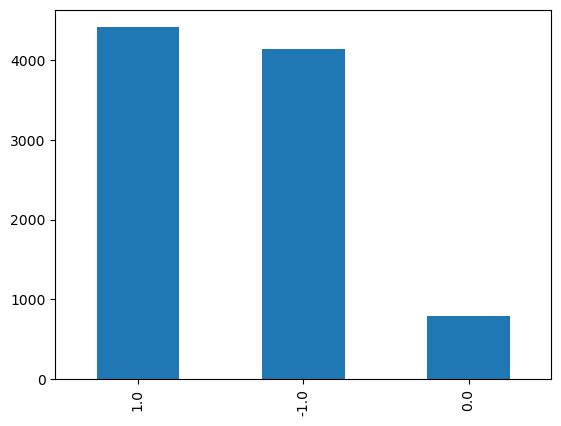

In [79]:
np.sign(msft_prices.Close.diff()).value_counts().plot.bar()

**The baseline model is roughly 50/50.**

### Genetic Programming

In [37]:
for index_range in msft_indexes:
    results['msft'][index_range] = {}
    lower_index, upper_index = index_range
    window_size = 9
    x_train = np.arange(1, window_size + 1).reshape(-1, 1)
    x_test = np.array(x_train[-1] + 1).reshape(1, -1)
    actual_direction = []
    predicted_direction = []
    for y in sliding_window_view(msft_prices.iloc[lower_index:upper_index].Close.values, window_size + 1):
        est_gp = SymbolicRegressor(population_size=2000,
                                   generations=20, stopping_criteria=0.05,
                                   p_crossover=0.7, p_subtree_mutation=0.1,
                                   p_hoist_mutation=0.05, p_point_mutation=0.1,
                                   max_samples=0.9, verbose=1,
                                   parsimony_coefficient=0.004, random_state=0, n_jobs=-1)
        y_train = np.array(y[:-1])
        x_train = np.arange(1, y_train.shape[0] + 1).reshape(-1, 1)
        est_gp.fit(x_train, y_train)
        actual_value = y[-1]

        ## stats
        # predicted direction
        prediction_value = est_gp.predict(x_test)[0]
        previous_day = y[-2]
        did_increase = 1 if actual_value - previous_day > 0 else -1
        predicted_increase = 1 if prediction_value - previous_day > 0 else -1
        if did_increase == predicted_increase:
            print('Prediction direction correct')
        else:
            print('Prediction direction wrong')
        actual_direction.append(did_increase)
        predicted_direction.append(predicted_increase)

        print('-' * 70)
    print(actual_direction, predicted_direction)
    results['msft'][index_range]['actual_direction'] = actual_direction
    results['msft'][index_range]['predicted_direction'] = predicted_direction

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.41           191488        7        0.0389073        0.0360423      1.23m
Prediction direction wrong
----------------------------------------------------------------------
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.41           191488        7        0.0349986        0.0520223     37.88s
Prediction direction correct
----------------------------------------------------------------------
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------

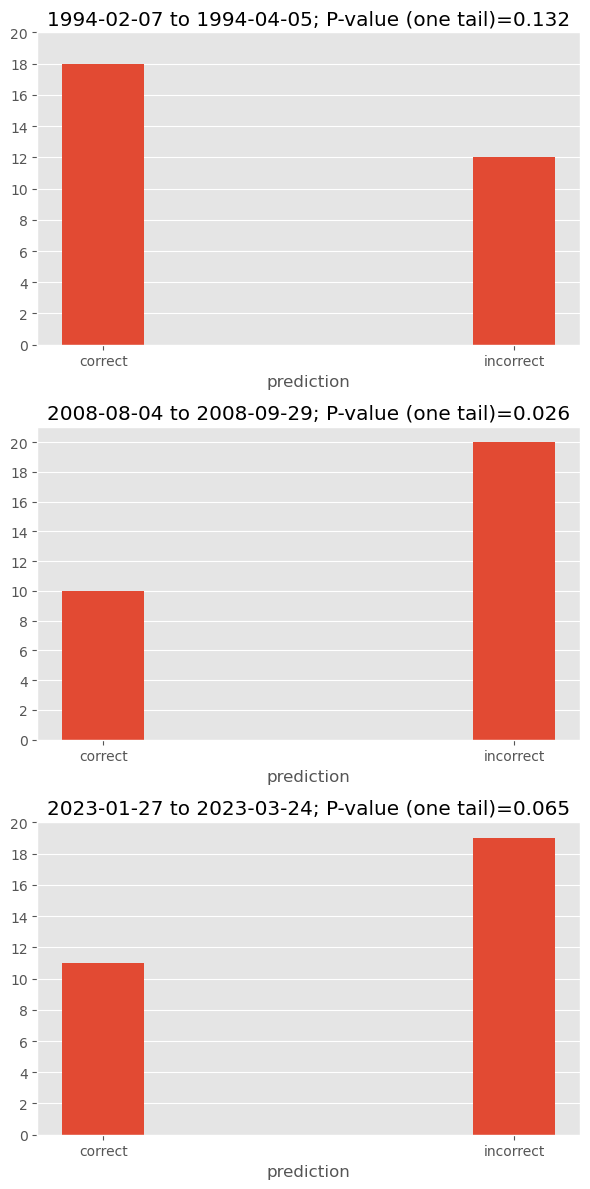

In [114]:
plt.figure(figsize=(6,12))
plt.style.use('ggplot')
for plot_number, (indexes, values) in enumerate(results['msft'].items(), 1):
    lower_index, upper_index = indexes
    correct, incorrect = utilities.compare_predictions(values['actual_direction'], values['predicted_direction'])
    stat, pval = proportions_ztest(count=max(correct, incorrect), nobs=correct + incorrect, value=0.5, alternative='larger')
    plt.subplot(3, 1, plot_number)
    plt.bar(['correct', 'incorrect'], [correct, incorrect], width=0.2)
    plt.grid(visible=None, axis='x')
    plt.title(f'{msft_prices.iloc[lower_index].Date.strftime("%Y-%m-%d")} to {msft_prices.iloc[upper_index].Date.strftime("%Y-%m-%d")}; P-value (one tail)={pval:.3f}')
    plt.yticks(range(0, 22, 2))
    plt.xlabel('prediction')
    plt.tight_layout()

## Apple

### Baseline

<AxesSubplot:>

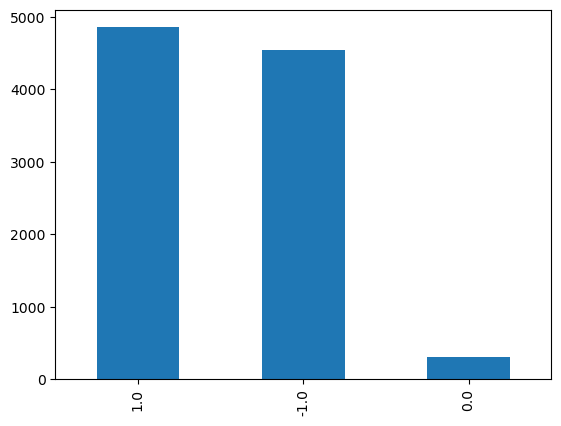

In [116]:
plt.style.use('default')
np.sign(aapl_prices.Close.diff()).value_counts().plot.bar()

**The baseline model is roughly 50/50.**

### Genetic Programming

In [132]:
start_timer = time.time()
for index_range in aapl_indexes:
    results['aapl'][index_range] = {}
    lower_index, upper_index = index_range
    window_size = 9
    x_train = np.arange(1, window_size + 1).reshape(-1, 1)
    x_test = np.array(x_train[-1] + 1).reshape(1, -1)
    actual_direction = []
    predicted_direction = []
    for y in sliding_window_view(aapl_prices.iloc[lower_index:upper_index].Close.values, window_size + 1):
        est_gp = SymbolicRegressor(population_size=2000,
                                   generations=20, stopping_criteria=0.05,
                                   p_crossover=0.7, p_subtree_mutation=0.1,
                                   p_hoist_mutation=0.05, p_point_mutation=0.1,
                                   max_samples=0.9, verbose=0,
                                   parsimony_coefficient=0.004, random_state=0, n_jobs=-1)
        y_train = np.array(y[:-1])
        est_gp.fit(x_train, y_train)
        actual_value = y[-1]

        ## stats
        # predicted direction
        prediction_value = est_gp.predict(x_test)[0]
        previous_day = y[-2]
        did_increase = 1 if actual_value - previous_day > 0 else -1
        predicted_increase = 1 if prediction_value - previous_day > 0 else -1
        actual_direction.append(did_increase)
        predicted_direction.append(predicted_increase)
    print(f'Index: {index_range}')
    print(utilities.calculate_elapsed(start_timer, time.time()))
    print(actual_direction, predicted_direction)
    results['aapl'][index_range]['actual_direction'] = actual_direction
    results['aapl'][index_range]['predicted_direction'] = predicted_direction
print(utilities.calculate_elapsed(start_timer, time.time()))

Index: (2000, 2039)
Elapsed 0.0 minutes 58.444623947143555 seconds
[-1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1] [-1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Index: (5837, 5876)
Elapsed 23.0 minutes 46.057717084884644 seconds
[-1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1] [1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1]
Index: (9674, 9713)
Elapsed 60.0 minutes 51.519492864608765 seconds
[-1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1] [-1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1]
Elapsed 60.0 minutes 51.51986598968506 seconds


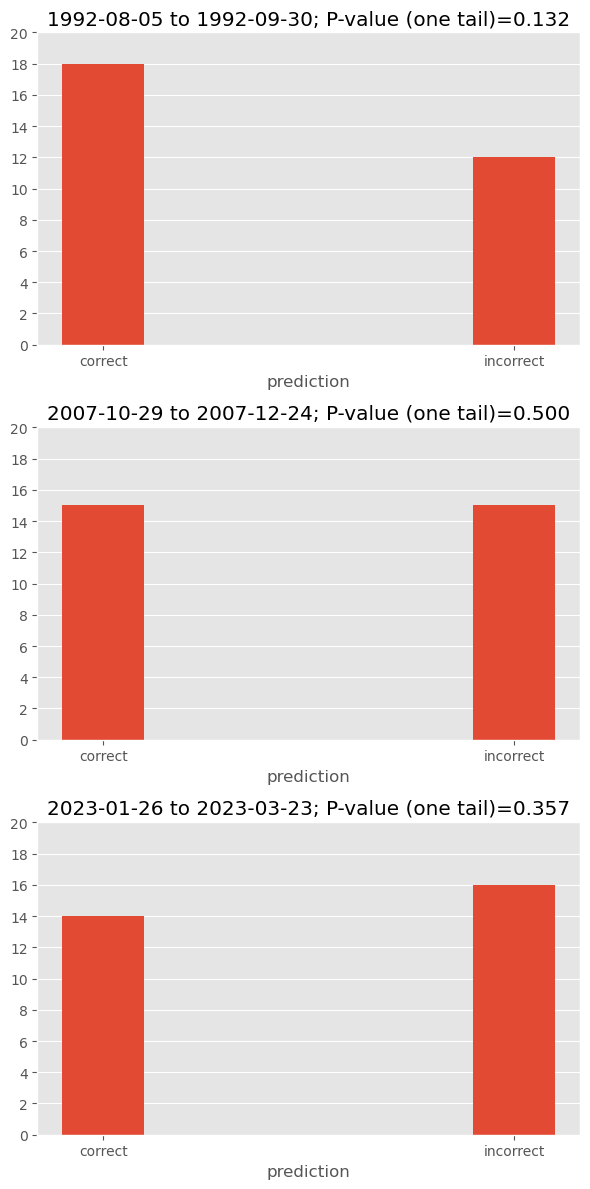

In [133]:
plt.figure(figsize=(6,12))
plt.style.use('ggplot')
for plot_number, (indexes, values) in enumerate(results['aapl'].items(), 1):
    lower_index, upper_index = indexes
    correct, incorrect = utilities.compare_predictions(values['actual_direction'], values['predicted_direction'])
    stat, pval = proportions_ztest(count=max(correct, incorrect), nobs=correct + incorrect, value=0.5, alternative='larger')
    plt.subplot(3, 1, plot_number)
    plt.bar(['correct', 'incorrect'], [correct, incorrect], width=0.2)
    plt.grid(visible=None, axis='x')
    plt.title(f'{aapl_prices.iloc[lower_index].Date.strftime("%Y-%m-%d")} to {aapl_prices.iloc[upper_index].Date.strftime("%Y-%m-%d")}; P-value (one tail)={pval:.3f}')
    plt.yticks(range(0, 22, 2))
    plt.xlabel('prediction')
    plt.tight_layout()